## Gradient Descent Model for locating the base station

In [26]:
from wcscore import WCsimEnvCore
import matplotlib.pyplot as plt

import numpy as np

In [27]:
np.random.seed(0)

## Environment Setup

In [29]:
env = WCsimEnvCore(server_ip='127.0.0.1', server_port=8877)

Server: Hello Client~ 
Connected to Server successfully.
The Simulator is ready.


## Generate Base Station and Users

In [30]:
env.reset()

# Add a station
env.add_station([0, 7, 0], [0,0,0], 2.4e9)
stations = env.ask_stations_info()
station_id = stations[0] 

# Add Users
n_user = 50
for i in range(n_user):
    random_position = list(np.multiply(np.random.rand(3), [200, 2, 200]) + [-100, 1, -100])
    print(random_position)
    env.add_user(random_position)
    
# Get list of users
user_ids = env.ask_users_info()

# Check the station status
for user_id in user_ids:
    env.connect_user_to_station(station_id, user_id)

[9.762700785464943, 2.430378732744839, 20.552675214328772]
[8.976636599379376, 1.8473095986778094, 29.17882261333122]
[-12.482557747461499, 2.7835460015641598, 92.73255210020585]
[-23.31169623484446, 2.583450076165329, 5.778983950580894]
[13.608912218786458, 2.851193276585322, -85.7927883604226]
[-82.57414005969186, 1.0404367948806514, 66.5239691095876]
[55.63135018997011, 2.7400242964936385, 95.72366844655281]
[59.83171284334472, 1.9229587245058637, 56.10583525729109]
[-76.34511482621335, 2.279842042655048, -71.32934251819071]
[88.93378340991677, 2.0436966435001436, -17.067612001895284]
[-47.088877579074605, 2.548467378868433, -8.76993355669029]
[13.6867897737297, 1.0375796008727103, 23.527099415175414]
[22.419144544484283, 2.233867993749514, 88.74961570292484]
[36.364059820696696, 1.719015801147572, -12.593609240131713]
[39.526239185452965, 1.1204509432585397, 33.353343089133546]
[34.12757392363187, 1.4207651221476818, -74.21474046902934]
[-36.91432981516323, 1.7274215418852452, 14.0

In [31]:
for user_id in user_ids:
    print(env.ask_user_info(user_id))

{'id': 0, 'position': [9.762701, 2.430379, 20.552675], 'station': 0, 'path loss': -66.082077}
{'id': 1, 'position': [8.976637, 1.84731, 29.178823], 'station': 0, 'path loss': -68.262436}
{'id': 2, 'position': [-12.482558, 2.783546, 92.732552], 'station': 0, 'path loss': -118.230667}
{'id': 3, 'position': [-23.311695, 2.58345, 5.778984], 'station': 0, 'path loss': -66.456558}
{'id': 4, 'position': [13.608912, 2.851193, -85.792786], 'station': 0, 'path loss': None}
{'id': 5, 'position': [-82.574142, 1.040437, 66.523972], 'station': 0, 'path loss': -115.440071}
{'id': 6, 'position': [55.631351, 2.740024, 95.723671], 'station': 0, 'path loss': -78.704758}
{'id': 7, 'position': [59.831715, 1.922959, 56.105835], 'station': 0, 'path loss': None}
{'id': 8, 'position': [-76.345116, 2.279842, -71.329346], 'station': 0, 'path loss': None}
{'id': 9, 'position': [88.933784, 2.043697, -17.067612], 'station': 0, 'path loss': -115.271416}
{'id': 10, 'position': [-47.088879, 2.548467, -8.769934], 'stat

In [32]:
# MVP for first model
itr = 100
step_rate = 1
ep = 0.001
avg_pl_list = [env.ask_station_info(station_id)['average path loss']]
x_list = [env.ask_station_info(station_id)['position'][0]]
z_list = [env.ask_station_info(station_id)['position'][2]]
for i in range(itr):
    station = env.ask_station_info(station_id)
    position = station['position']
    rotation = station['rotation']
    pos_x_plus_ep = list(np.array(position) + [ep, 0, 0])
    pot_x_min_ep = list(np.array(position) - [ep, 0, 0])
    pos_z_plus_ep = list(np.array(position) + [0, 0, ep])
    pot_z_min_ep = list(np.array(position) - [0, 0, ep])
    # f_x_plus
    env.move_station_to(station_id, pos_x_plus_ep, rotation)
    x_plus_ep_pl =  env.ask_station_info(station_id)['average path loss']
    if x_plus_ep_pl == None:
        x_plus_ep_pl = -500
    # f_x_min
    env.move_station_to(station_id, pot_x_min_ep, rotation)
    x_min_ep_pl =  env.ask_station_info(station_id)['average path loss']
    if x_min_ep_pl == None:
        x_min_ep_pl = -500
    
    # f_x_plus
    env.move_station_to(station_id, pos_z_plus_ep, rotation)
    z_plus_ep_pl =  env.ask_station_info(station_id)['average path loss']
    if z_plus_ep_pl == None:
        z_plus_ep_pl = -500
    # f_z_min
    env.move_station_to(station_id, pot_z_min_ep, rotation)
    z_min_ep_pl =  env.ask_station_info(station_id)['average path loss']
    if z_min_ep_pl == None:
        z_min_ep_pl = -500
    
    # Calculate dx
    dx = (x_plus_ep_pl - x_min_ep_pl)/(2*ep)
    dz = (z_plus_ep_pl - z_min_ep_pl)/(2*ep)
    if np.round(dx, 10) == 0:
        break
    if np.round(dz, 10) == 0:
        break
    # update position + because step up to local max since pl are minus
    position = list(np.array(position) + [dx*step_rate, 0, dz*step_rate])
    env.move_station_to(station_id, position, rotation)
    improved_pl =  env.ask_station_info(station_id)['average path loss']
    avg_pl_list.append(improved_pl)
    x_list.append(env.ask_station_info(station_id)['position'][0])
    z_list.append(env.ask_station_info(station_id)['position'][2])
    print(improved_pl)

-83.164352
-83.158005
-83.142426
-83.125359
-83.101654
-83.126434


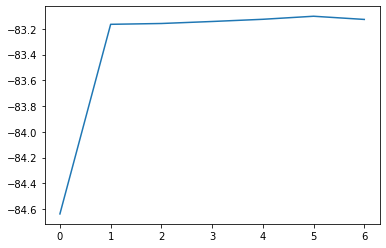

In [33]:
plt.plot(avg_pl_list)

In [37]:
station_id = stations[0]
heat_map = []

for x in range(-10,10):
    z_row = []
    for z in range(-10, 10):
        position = [x, 7, z]
        env.move_station_to(station_id, position, [0, 0, 0])
        avg_pl = env.ask_station_info(station_id)['average path loss']
        if avg_pl is None:
            avg_pl = -500
        z_row.append(avg_pl)
    heat_map.append(x_row)
    
plt.imshow(heat_map, cmap='hot', interpolation='nearest')
plt.show()

NameError: name 'x_row' is not defined

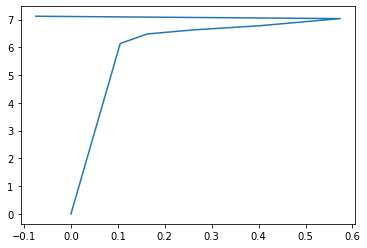

In [34]:
plt.plot(x_list[:10], z_list[:10])

In [35]:
x_list

[0.0, 0.105, 0.1625, 0.25875, 0.40125, 0.57375, -0.075]

In [36]:
final_position =  env.ask_station_info(station_id)['position']
final_position

[-0.075, 7.0, 7.1215]

In [ ]:
for user_id in user_ids:
    print(env.ask_user_info(user_id))

In [ ]:
env.disconnect()